In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing Libraries**
Libraries included:


*   Numpy
*   Pandas
*   MatPlotLib
*   TensorFlow




In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
from PIL import Image

## **Loading Data and Typecasting**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
print(np.ptp(x_train))
print(x_train.shape)

255
(50000, 32, 32, 3)


In [ ]:
m_train = x_train.shape[0]
m_test = x_test.shape[0]

print("Training Data Size =", m_train)
print("Test Data Size =", m_test)

Training Data Size = 50000
Test Data Size = 10000


In [ ]:
# Creating training sets and normalizing
norm_X = np.linalg.norm(x_train, ord = 2, axis = 0)
x_train = x_train / norm_X

In [ ]:
print(np.ptp(x_train))
print(np.ptp(x_test))

0.009820172925945007
255


In [ ]:
# Creating training sets and normalizing
norm_X = np.linalg.norm(x_test, ord = 2, axis = 0)
x_test = x_test / norm_X

In [ ]:
print("Shape of X test set:", x_test.shape)
print("Shape of Y test set:", y_test.shape)

Shape of X test set: (10000, 32, 32, 3)
Shape of Y test set: (10000, 1)


In [ ]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#training = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#testing = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#training = training.cache()
#training = training.prefetch(AUTOTUNE)
#training = aug(training)

#testing = testing.prefetch(AUTOTUNE)

In [ ]:
class DataAugmentation:

    # Function to translate the image in either of 4 directions by a fixed number of pixels
    def img_translation(img, shift = 5, direction = 'right', roll = True):
        assert direction in ['right', 'left', 'up', 'down'], "Shift direction must be right, left, up or down"

        if direction == 'right' or 'left':
            assert shift < img.shape[0], "Shift must be smaller than width"

        if direction == 'up' or 'down':
            assert shift < img.shape[1], "Shift must be smaller than height"

        img = img.copy()
        if direction == 'right':
            slice = img[:, -shift:].copy()
            img[:, shift:] = img[:, :-shift]
            if roll:
                img[:, :shift] = slice

        if direction == 'left':
            slice = img[:, :shift].copy()
            img[:, :-shift] = img[:, shift:]
            if roll:
                img[:, -shift:] = slice

        if direction == 'up':
            slice = img[:shift, :].copy()
            img[:-shift, :] = img[shift:, :]
            if roll:
                img[-shift:, :] = slice

        if direction == 'down':
            slice = img[-shift:, :].copy()
            img[shift:, :] = img[:-shift, :]
            if roll:
                img[:, :shift] = slice

        return img

    # Function to crop out a random fixed sized patch of the image
    def random_patch(img, crop_size = (27, 27)):
        assert crop_size[0] < img.shape[0] and crop_size < img.shape[1], "Crop size should be smaller than image size"

        img = img.copy()

        w, h = img.shape[:2]
        x, y = np.random.randint(h - crop_size[0], w - crop_size[1])

        img = img[y:y + crop_size[0], x:x + crop_size[1]]

        return img    

    # Funciton to change the colour of the image by reducing intensity of one of the channels
    def colour_change(img, colour_channel = 'r', ratio = 0.5):
        assert colour_channel in 'rgb', "Colour channel must be r, g or b"
        assert ratio < 1.0 and ratio >= 0.0, "Ratio must be greater than equal to 0.0 and less than 1.0"

        img = img.copy()
        idx = 'rgb'.index(colour_channel)
        img[:, :, idx] = img[:, :, idx] * ratio

        return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


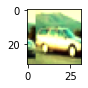

In [ ]:
plt.figure(figsize = (1, 1))
img_temp = DataAugmentation.img_translation(x_train[4])
img_temp = DataAugmentation.colour_change(img_temp, colour_channel = 'b')
plt.imshow(img_temp * 255.0)

In [ ]:
def custom_aug(img, label):
    img_temp1 = DataAugmentation.img_translation(img, direction = 'right')
    img_temp2 = DataAugmentation.img_translation(img, direction = 'up')
    img_temp3 = DataAugmentation.colour_change(img, colour_channel = 'r')
    img_temp4 = DataAugmentation.colour_change(img, colour_channel = 'g')    
    img_temp5 = DataAugmentation.colour_change(img, colour_channel = 'b')

    aug = [img_temp1, img_temp2, img_temp3, img_temp4, img_temp5]
    aug_label = [label, label, label, label, label]
    aug = np.array(aug)
    aug_label = np.array(aug_label)

    return aug, aug_label

In [ ]:
aug_img, aug_label = custom_aug(x_train[100], y_train[100])

In [ ]:
aug_img

In [ ]:
for i in range(3000):
    idx = np.random.randint(0, 50001)
    aug_img, aug_label = custom_aug(x_train[idx], y_train[idx])
    if i == 0:
        x_aug = aug_img
        x_aug_label = aug_label
    else:
        x_aug = np.append(x_aug, aug_img, axis = 0)
        x_aug_label = np.append(x_aug_label, aug_label, axis = 0)
    
print(x_aug.shape)

(15000, 32, 32, 3)


In [ ]:
x_train_aug = np.append(x_train, x_aug, axis = 0)
y_train_aug = np.append(y_train, x_aug_label, axis = 0)

print(x_train_aug.shape)
print(y_train_aug.shape)

(65000, 32, 32, 3)
(65000, 1)


# **Using TensorFlow**

### Fully Connected Network with only Dense Connections

In [ ]:
def adjacent_sum(a, i, n):
  j1 = max(0, int(i - (n / 2)))
  j2 = min(a.shape[3] - 1, int(i + (n / 2)))
  sum = np.zeros((a.shape[0], a.shape[1], a.shape[2]))

  for j in range(j1, j2 + 1):
    sum += np.square(a[:, :, :, j])

  return sum

In [ ]:
def response_norm2(a, k = 2, alpha_response_norm = 0.0001, beta_response_norm = 0.75, n = 5):
    x = tf.nn.local_response_normalization(a, depth_radius = n, bias = k, alpha= alpha_response_norm, beta= beta_response_norm)

    return x

In [ ]:
def response_norm(a, k = 2, alpha_response_norm = 0.0001, beta_response_norm = 0.75, n = 5):
  d = np.zeros(a.shape)
  for i in range(0, a.shape[2]):
    d[:, :, i] = a[:, :, i] / ((k + (alpha_response_norm * adjacent_sum(a, i, n))) ** beta_response_norm)

  return d


#k = 2
#alpha_response_norm = 0.0001
#beta_response_norm = 0.75
#n = 5
#d = np.zeros(b.shape)
#for i in range(0, b.shape[3]):
#  d[:, :, :, i] = b[:, :, :, i] / ((k + (alpha_response_norm * adjacent_sum(b, i, n))) ** beta_response_norm)

#print(d)
#print(d.shape)

In [ ]:
a = np.random.randn(2, 5, 5, 3)
b = layers.Conv2D(4, 3)(a)
b = keras.activations.relu(b)
print(b)
print("__________________________________________________________________________")
print("__________________________________________________________________________")
print("__________________________________________________________________________")
c = response_norm2(b)
print(c)

tf.Tensor(
[[[[0.         0.3058603  0.55950135 0.39511937]
   [0.         0.28819963 0.5649374  0.02023071]
   [0.         0.         0.         0.        ]]

  [[0.         0.         0.         1.6963229 ]
   [0.         0.27908647 0.6309761  0.10996975]
   [0.         0.         1.0370772  0.        ]]

  [[0.         0.         0.21197116 0.53569835]
   [0.         0.48514602 0.73159903 0.        ]
   [0.         0.         0.84013534 0.9731132 ]]]


 [[[0.         0.         0.         0.35208234]
   [0.06495925 0.8924943  0.46607724 0.95962   ]
   [0.         1.0193843  0.44775498 0.18105882]]

  [[0.         0.16540731 0.         0.2788244 ]
   [0.02254814 0.7574839  1.0553511  0.        ]
   [0.         0.         0.         0.7906439 ]]

  [[0.         0.         0.82322973 0.        ]
   [0.         0.         0.9535346  0.76042926]
   [0.         0.01391336 0.61223584 0.2823662 ]]]], shape=(2, 3, 3, 4), dtype=float32)
________________________________________________________

### Using Model Sub-classing

In [ ]:
class Dense(layers.Layer):
  def __init__(self, out_channels):
    super(Dense, self).__init__()
    self.dense = layers.Dense(units = out_channels, activation = 'relu')
    self.batchnorm = layers.BatchNormalization()

  def call(self, input_tensor):
    x = self.dense(input_tensor)
    x = self.batchnorm(x)
    return x

In [ ]:
class CNN5(layers.Layer):
  def __init__(self, channels=96, kernel_size = 5, padding='valid', stride=1):
    super(CNN5, self).__init__()
    self.cnn = layers.Conv2D(filters=channels, kernel_size = kernel_size, strides=(stride, stride), padding=padding)
    self.batchnorm = layers.BatchNormalization()

  def call(self, input_tensor):
    x = self.cnn(input_tensor)
    x = self.batchnorm(x)
    #print(x.shape)
    return x

In [ ]:
class CNN3(layers.Layer):
  def __init__(self, channels=256, kernel_size = 3, padding='valid', stride=1):
    super(CNN3, self).__init__()
    self.cnn = layers.Conv2D(filters=channels, kernel_size = kernel_size, strides=(stride, stride), padding=padding)
    self.batchnorm = layers.BatchNormalization()

  def call(self, input_tensor):
    x = self.cnn(input_tensor)
    x = self.batchnorm(x)
    #print(x.shape)
    return x

In [ ]:
class OverlappingPooling(layers.Layer):
    def __init__(self, pool = 3, stride = 1):
        super(OverlappingPooling, self).__init__()
        self.pool = layers.MaxPooling2D(pool_size = (pool, pool), strides = stride)

    def call(self, input_tensor):
        x = self.pool(input_tensor)
        return x

In [ ]:
def model():
  INPUT = layers.Input(shape = (32, 32, 3))
  
  # Conv Layer 1
  x = CNN5(channels=96)(INPUT)
  x = keras.activations.relu(x)
  x = response_norm2(a = x)
  x = OverlappingPooling(pool = 3, stride = 2)(x)
  x = keras.layers.Dropout(0.5)(x)

  # Conv Layer 2
  x = CNN3(channels=256)(x)
  x = keras.activations.relu(x)
  x = response_norm2(a = x)
  x = OverlappingPooling(pool = 3, stride = 1)(x)  
  x = keras.layers.Dropout(0.5)(x)

  # Conv Layer 3
  x = CNN3(channels = 384, stride = 1)(x)
  x = keras.activations.relu(x)

  # Conv Layer 4
  x = CNN3(channels = 384, stride = 1)(x)
  x = keras.activations.relu(x)

  # Conv Layer 5
  x = CNN3(channels = 256, stride = 1)(x)
  x = keras.activations.relu(x)
  x = OverlappingPooling(pool = 3, stride = 1)(x)

  # Dense Layer 1
  x = layers.Flatten()(x)
  x = Dense(out_channels = 1024)(x)
  x = keras.activations.relu(x)

  # Dense Layer 2
  x = Dense(out_channels = 1024)(x)
  x = keras.activations.relu(x)
  OUTPUT = Dense(out_channels = 10)(x)

  model = keras.Model(inputs = INPUT, outputs = OUTPUT)

  return model

In [ ]:
my_model = model()
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cn_n5_1 (CNN5)               (None, 28, 28, 96)        7680      
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 28, 28, 96)        0         
_________________________________________________________________
tf.nn.local_response_normali (None, 28, 28, 96)        0         
_________________________________________________________________
overlapping_pooling_1 (Overl (None, 13, 13, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 96)        0         
_________________________________________________________________
cn_n3_1 (CNN3)               (None, 11, 11, 256)       222464

In [ ]:
my_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.01),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
history1 = my_model.fit(x_train_aug, y_train_aug, batch_size = 128, epochs = 3, shuffle = True)

Epoch 1/3
508/508 [==============================] - 1585s 3s/step - loss: 1.7253 - accuracy: 0.3634
Epoch 2/3
508/508 [==============================] - 1561s 3s/step - loss: 1.2630 - accuracy: 0.5485
Epoch 3/3
508/508 [==============================] - 1565s 3s/step - loss: 1.0624 - accuracy: 0.6260


In [ ]:
my_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

history2 = my_model.fit(x_train_aug, y_train_aug, batch_size = 64, epochs = 5, initial_epoch = 3, shuffle = True, validation_split = 0.1)

Epoch 4/5
915/915 [==============================] - 1456s 2s/step - loss: 0.8798 - accuracy: 0.6935 - val_loss: 1.9513 - val_accuracy: 0.3928
Epoch 5/5
915/915 [==============================] - 1447s 2s/step - loss: 0.7874 - accuracy: 0.7248 - val_loss: 5.1755 - val_accuracy: 0.1125


In [ ]:
history3 = my_model.fit(x_train, y_train, batch_size = 128, epochs = 10, initial_epoch = 5, shuffle = True)

Epoch 6/10
391/391 [==============================] - 1125s 3s/step - loss: 0.6200 - accuracy: 0.7865
Epoch 7/10
391/391 [==============================] - 1120s 3s/step - loss: 0.5586 - accuracy: 0.8093
Epoch 8/10
391/391 [==============================] - 1127s 3s/step - loss: 0.4933 - accuracy: 0.8305
Epoch 9/10
391/391 [==============================] - 1128s 3s/step - loss: 0.4265 - accuracy: 0.8555
Epoch 10/10
391/391 [==============================] - 1131s 3s/step - loss: 0.3774 - accuracy: 0.8677


In [ ]:
my_model.save('/content/drive/MyDrive/Colab Notebooks/AlexNet/Model')

acc = [0.] + history1.history['accuracy']

loss = history1.history['loss']

np.save('/content/drive/MyDrive/Colab Notebooks/AlexNet/acc', acc)
np.save('/content/drive/MyDrive/Colab Notebooks/AlexNet/loss', loss)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AlexNet/Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AlexNet/Model/assets


In [ ]:
my_model2 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AlexNet/Model')

In [ ]:
my_model2.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
history4 = my_model2.fit(x_train, y_train, batch_size = 128, epochs = 15, initial_epoch = 10, shuffle = True)

Epoch 11/15
391/391 [==============================] - 1153s 3s/step - loss: 0.1799 - accuracy: 0.9419
Epoch 12/15
391/391 [==============================] - 1143s 3s/step - loss: 0.1055 - accuracy: 0.9684
Epoch 13/15
391/391 [==============================] - 1141s 3s/step - loss: 0.0791 - accuracy: 0.9763
Epoch 14/15
391/391 [==============================] - 1136s 3s/step - loss: 0.0602 - accuracy: 0.9823
Epoch 15/15
391/391 [==============================] - 1137s 3s/step - loss: 0.0547 - accuracy: 0.9834


In [ ]:
my_model2.save('/content/drive/MyDrive/Colab Notebooks/AlexNet/Model 2')


acc += history4.history['accuracy']

loss += history4.history['loss']

np.save('/content/drive/MyDrive/Colab Notebooks/AlexNet', acc)
np.save('/content/drive/MyDrive/Colab Notebooks/AlexNet', loss)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AlexNet/Model 2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AlexNet/Model 2/assets


In [ ]:
my_model3 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/AlexNet/Model 2')

In [ ]:
my_model3.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
history5 = my_model3.fit(x_train, y_train, batch_size = 128, epochs = 18, initial_epoch = 15, shuffle = True)

Epoch 16/18
391/391 [==============================] - 1190s 3s/step - loss: 0.0294 - accuracy: 0.9925
Epoch 17/18
391/391 [==============================] - 1192s 3s/step - loss: 0.0181 - accuracy: 0.9962
Epoch 18/18
391/391 [==============================] - 1181s 3s/step - loss: 0.0141 - accuracy: 0.9975


In [ ]:
my_model3.evaluate(x_test, y_test, batch_size = 128, verbose = 1)

79/79 [==============================] - 51s 637ms/step - loss: 1.7724 - accuracy: 0.6230


[1.7723822593688965, 0.6230000257492065]

### Data Augmentation

